# An Analysis of PGA Tour Professionals
## How different are their shots gained?  
This notebook is a dive into the "Shots Gained" or "Strokes Gained" metric and how different it is for different players.  
The data for this has been acquired from [Advanced Sports Analytics](https://www.advancedsportsanalytics.com/pga-raw-data).
## What does shots gained mean?  
The shots gained statistic seems to be of increasing popularity in the golf community, but what does it actually tell us?  
The metric compares a players performance in particular parts of the game to the rest of the field.  
If a player shoots 2 strokes under the average of the field, they gain 2 strokes whereas someone shooting 2 strokes above the field would gain -2 shots.  
We also need to understand which parts of the game are differentiated in the shots gained statistic:  
**Shots Gained Total**  
Measures a players performance overall against the field.  
**Shots Gained Tee to Green**. 
Measures a players performance agains the field including everything before putting.  
**Shots Gained Putting**
Measures the performance against the field while putting.  
Taking into acount what we know about "Shots Gained Tee to Green" it is only locical that:  
**Shots Gained Tee to Green + Shots Gained Putting = Shots Gained Total**  
**Shots Gained Around the Green**  
Takes into account all shots taken within 30 yards (ca. 27.4m) off the edge of the green, but not the shots taken on the green  
**Shots Gained Approach**  
This includes all shots that are not off the tee on par-4 or par-5 holes, not included in "Around the Green" and "Putting". It does include shots off the tee on par-3 holes.  
**Shots Gained Off the Tee**  
Measures the performance off the tee on par-4 and par-5 holes, not on par-3 holes as those are included in the "Shots Gained Approach" statistic.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# read data into DataFrame
data = pd.read_csv('PGA_Raw_Data_2017-2022.csv')
data = data.drop(['hole_DKP', 'hole_FDP', 'hole_SDP', 
                  'streak_DKP', 'streak_FDP', 'streak_SDP', 
                  'n_rounds', 'finish_DKP', 'finish_FDP', 
                  'finish_SDP', 'total_DKP', 'total_FDP', 
                  'total_SDP', 'Unnamed: 2', 'Unnamed: 3', 
                  'Unnamed: 4', 'purse', 'no_cut'],
                 axis=1
                );  # the semicolon supresses output, w/o it the df would be printed here

In [3]:
# take a look at the data
data.head(3)

,Player_initial_last,tournament id,player id,hole_par,strokes,made_cut,pos,player,tournament name,course,date,season,Finish,sg_putt,sg_arg,sg_app,sg_ott,sg_t2g,sg_total
0,A. Ancer,401353224,9261,288,289,1,32.0,Abraham Ancer,The Memorial Tournament pres. by Nationwide,"Muirfield Village Golf Club - Dublin, OH",2022-06-05,2022,T32,0.20,-0.13,-0.08,0.86,0.65,0.85
1,A. Hadwin,401353224,5548,288,286,1,18.0,Adam Hadwin,The Memorial Tournament pres. by Nationwide,"Muirfield Village Golf Club - Dublin, OH",2022-06-05,2022,T18,0.36,0.75,0.31,0.18,1.24,1.60
2,A. Lahiri,401353224,4989,144,147,0,NaN,Anirban Lahiri,The Memorial Tournament pres. by Nationwide,"Muirfield Village Golf Club - Dublin, OH",2022-06-05,2022,CUT,-0.56,0.74,-1.09,0.37,0.02,-0.54


Some columns like 'tournament name' contain white spaces, which would make working with them later on harder, so we will fix this.  
And just to be more consistent every column name will be lower case.

In [4]:
new_names = {
    'Player_initial_last':'player_initial_last', 
    'tournament id':'tournament_id', 
    'player id':'player_id', 
    'tournament name': 'tournament_name', 
    'Finish':'finish'}

data.rename(columns=new_names, inplace=True)

data.head(2)

,player_initial_last,tournament_id,player_id,hole_par,strokes,made_cut,pos,player,tournament_name,course,date,season,finish,sg_putt,sg_arg,sg_app,sg_ott,sg_t2g,sg_total
0,A. Ancer,401353224,9261,288,289,1,32.0,Abraham Ancer,The Memorial Tournament pres. by Nationwide,"Muirfield Village Golf Club - Dublin, OH",2022-06-05,2022,T32,0.20,-0.13,-0.08,0.86,0.65,0.85
1,A. Hadwin,401353224,5548,288,286,1,18.0,Adam Hadwin,The Memorial Tournament pres. by Nationwide,"Muirfield Village Golf Club - Dublin, OH",2022-06-05,2022,T18,0.36,0.75,0.31,0.18,1.24,1.60


## Data Understanding

**player_initial_last**  
Initial of the players first name and their full last name.  
**tournament_id**  
Unique id for each tournament.  
**player_id**  
Unique id for each player.  
**hole_par**  
Number of strokes to score a par overall.  
**strokes**  
Number of strokes the player needed for the tournament.  
**made_cut**  
0: did not make cut  
1: made the cut  
**pos**  
Position of the player in the tournament.  
**player**  
The player's full name.  
**tournament name**
Name of the tournament.  
**course**  
Golf course on which was played.  
**date**  
Date of the tournament, format YYYY-MM-DD  
**season**  
Year of the season (2017 - 2022). Keep in mind that season 2017 started in 2016 and so on.  
**finish**  
Finishing position of the player, if the player was cut the 'Finish' is 'CUT'.  
**sg_put**  
Shots gained while putting.  
**sg_arg**  
Shots gained around the green.  
**sg_app**  
Shots gained during approach.  
**sg_ott**  
Shots gained off the tee.  
**sg_t2g**  
Shots gained tee to green.  
**sg_total**  
Shots gained in total.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28525 entries, 0 to 28524
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   player_initial_last  28525 non-null  object 
 1   tournament_id        28525 non-null  int64  
 2   player_id            28525 non-null  int64  
 3   hole_par             28525 non-null  int64  
 4   strokes              28525 non-null  int64  
 5   made_cut             28525 non-null  int64  
 6   pos                  16167 non-null  float64
 7   player               28525 non-null  object 
 8   tournament_name      28525 non-null  object 
 9   course               28525 non-null  object 
 10  date                 28525 non-null  object 
 11  season               28525 non-null  int64  
 12  finish               23524 non-null  object 
 13  sg_putt              23523 non-null  float64
 14  sg_arg               23523 non-null  float64
 15  sg_app               23523 non-null 

## Cleaning up

A lot of columns do not use the data type *object* which is not nice to work with, so we will fix that.

In [6]:
data.player_initial_last = data.player_initial_last.astype('category')

data.player = data.player.astype('category')

data.tournament_name = data.tournament_name.astype('category')

data.course = data.course.astype('category')

data.date = data.date.astype('datetime64')

data.finish = data.finish.astype('category')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28525 entries, 0 to 28524
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   player_initial_last  28525 non-null  category      
 1   tournament_id        28525 non-null  int64         
 2   player_id            28525 non-null  int64         
 3   hole_par             28525 non-null  int64         
 4   strokes              28525 non-null  int64         
 5   made_cut             28525 non-null  int64         
 6   pos                  16167 non-null  float64       
 7   player               28525 non-null  category      
 8   tournament_name      28525 non-null  category      
 9   course               28525 non-null  category      
 10  date                 28525 non-null  datetime64[ns]
 11  season               28525 non-null  int64         
 12  finish               23524 non-null  category      
 13  sg_putt              23523 non-

Let's take a look at a quick statistical overview of the data.

In [7]:
data.describe()

,tournament_id,player_id,hole_par,strokes,made_cut,pos,season,sg_putt,sg_arg,sg_app,sg_ott,sg_t2g,sg_total
count,2.852500e+04,2.852500e+04,28525.000000,28525.000000,28525.000000,16167.000000,28525.000000,23523.000000,23523.000000,23523.000000,23523.000000,23523.000000,23524.000000
mean,3.013480e+08,1.022799e+05,224.712428,223.119755,0.598422,33.883714,2019.428466,-0.125924,-0.044617,-0.108220,-0.049563,-0.202325,-0.323437
std,1.734438e+08,6.523901e+05,70.446659,66.811562,0.490226,22.518739,1.662580,1.121120,0.728476,1.117115,0.803879,1.638853,1.972278
min,2.689000e+03,5.000000e+00,70.000000,66.000000,0.000000,1.000000,2017.000000,-5.990000,-5.410000,-7.510000,-7.740000,-13.950000,-13.670000
25%,4.010252e+08,1.264000e+03,143.000000,146.000000,0.000000,15.000000,2018.000000,-0.780000,-0.450000,-0.750000,-0.460000,-1.100000,-1.410000
50%,4.010566e+08,4.449000e+03,280.000000,271.000000,1.000000,32.000000,2019.000000,-0.040000,-0.010000,-0.010000,0.040000,-0.030000,-0.180000
75%,4.012430e+08,7.001000e+03,287.000000,281.000000,1.000000,51.000000,2021.000000,0.620000,0.410000,0.635000,0.480000,0.910000,1.040000
max,4.013669e+08,4.845309e+06,292.000000,313.000000,1.000000,999.000000,2022.000000,4.300000,3.170000,4.140000,2.470000,5.570000,7.010000


Now let's see how many missing data points we have.

In [8]:
data.isnull().sum()

player_initial_last        0
tournament_id              0
player_id                  0
hole_par                   0
strokes                    0
made_cut                   0
pos                    12358
player                     0
tournament_name            0
course                     0
date                       0
season                     0
finish                  5001
sg_putt                 5002
sg_arg                  5002
sg_app                  5002
sg_ott                  5002
sg_t2g                  5002
sg_total                5001
dtype: int64

[Text(0.5, 1.0, 'Missing Data'),
 Text(0.5, 14.09375, 'Columns'),
 Text(33.0, 0.5, 'Data Points')]

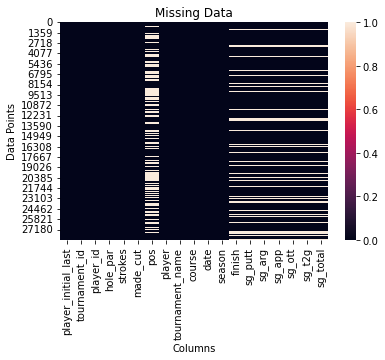

In [9]:
sns.heatmap(data.isnull()).set(title = 'Missing Data', xlabel = 'Columns', ylabel = 'Data Points')

As we can see, we have a lot of missing data, especially in the position column, but surprisingly a lot less in the finish column. We will now look into the distribution of the columns with missing data to decide our further strategy.

However we can not look at the distribution of 'finish' together with the other columns, because this columns contains categorical data.

/Users/lorenztreimer/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/lorenztreimer/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/lorenztreimer/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level f

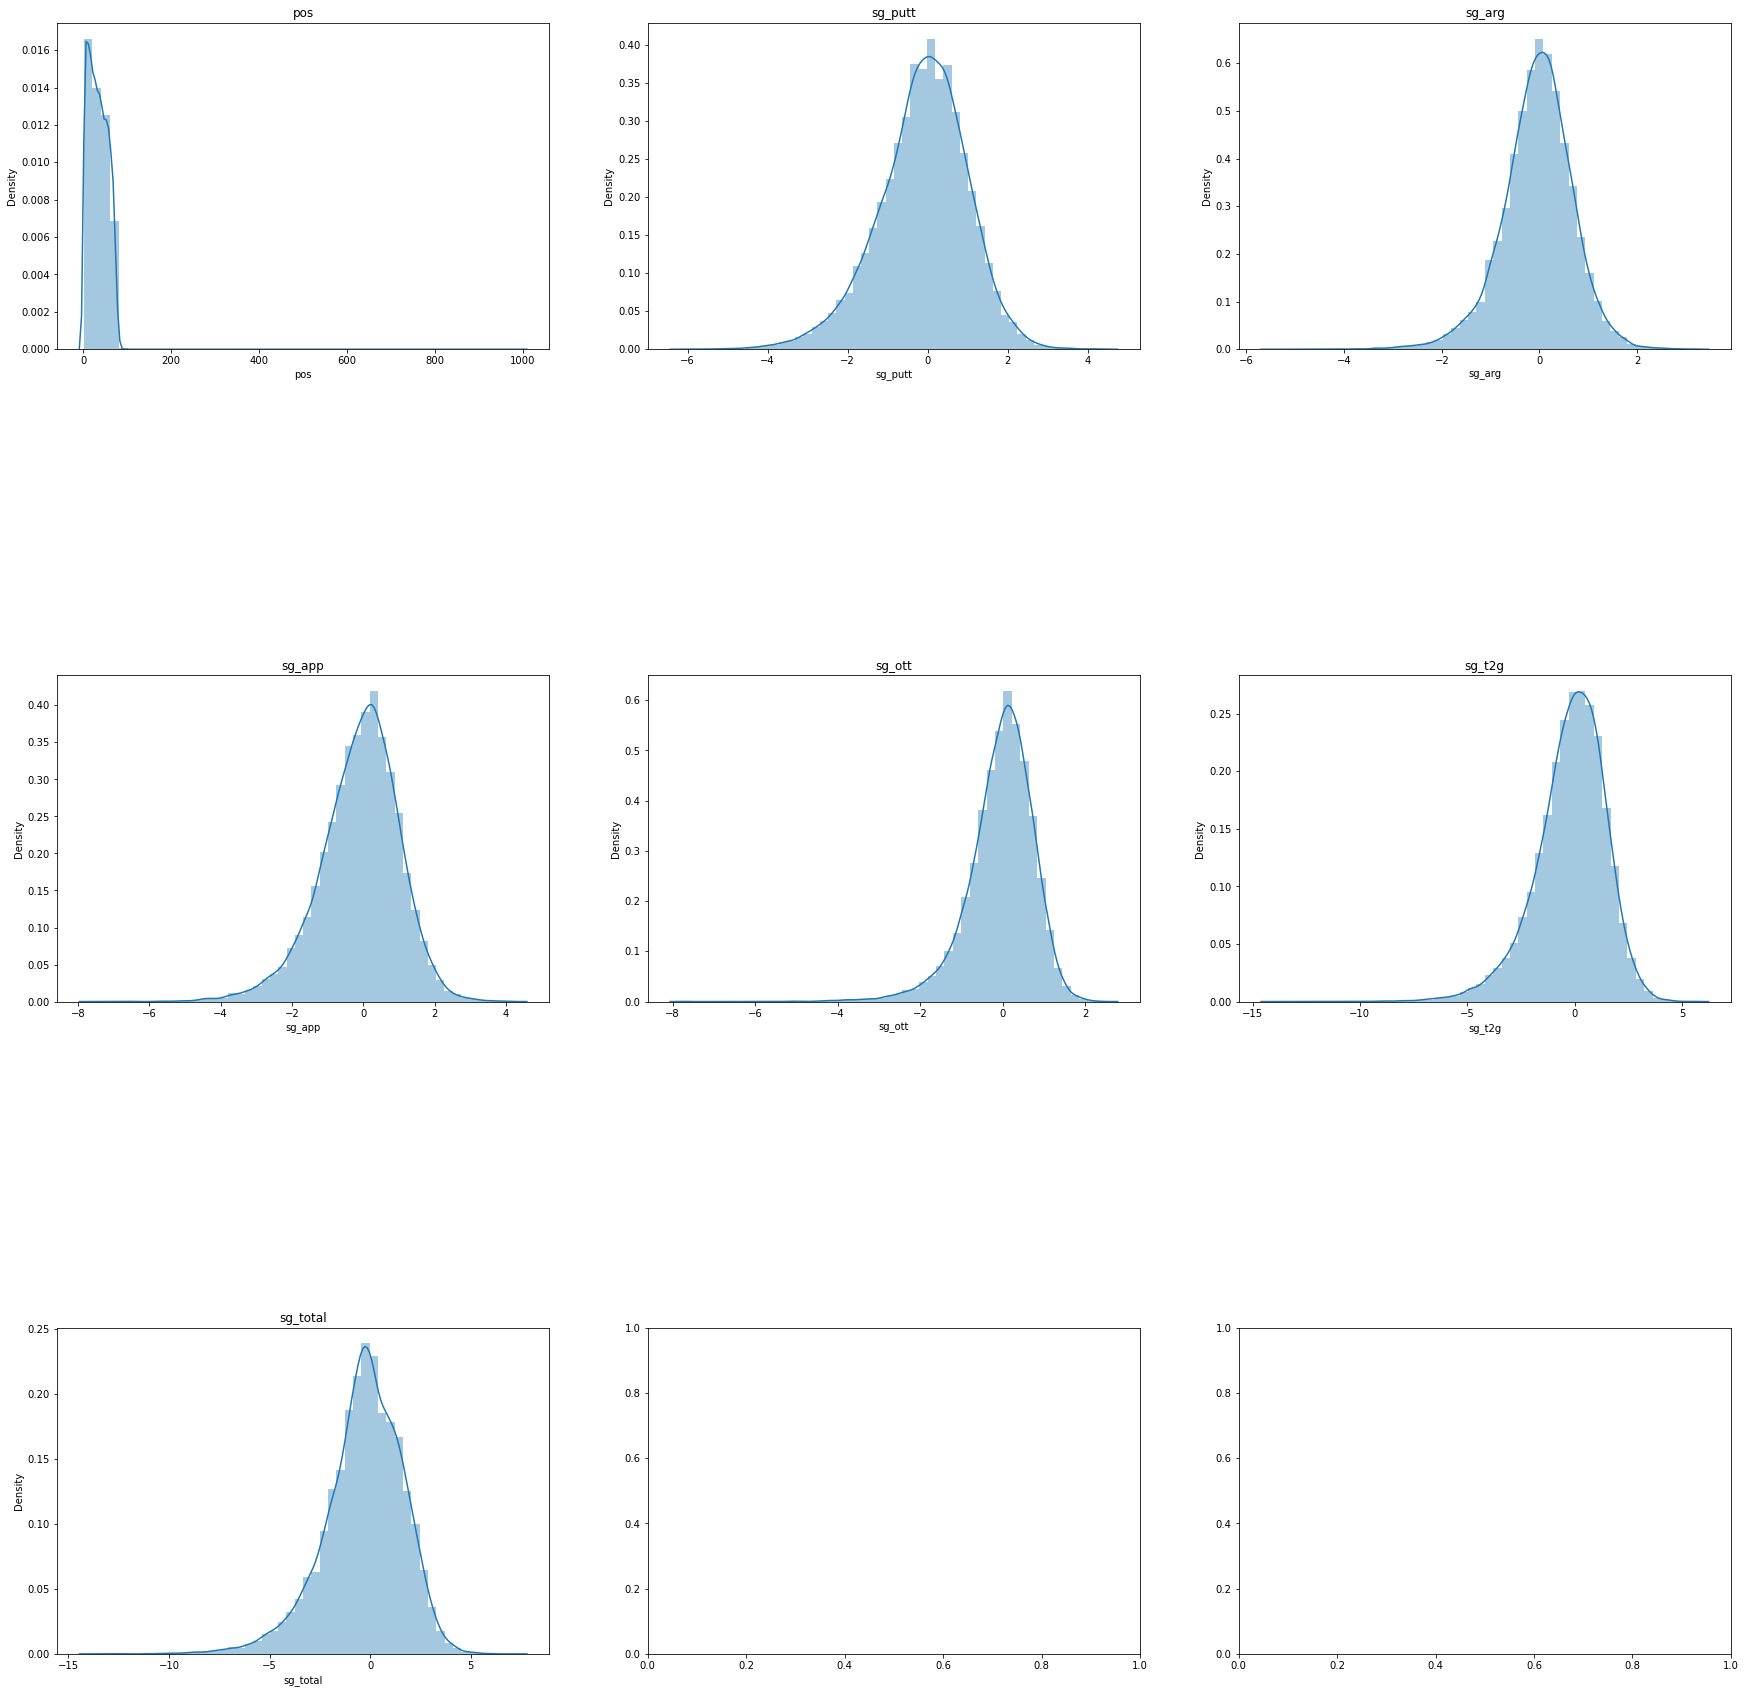

In [10]:
# first create a list with the columns that are missing data
missing_data_cols = ['pos', 'sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g', 'sg_total']

row = 0
col = 0

f, ax = plt.subplots(nrows=3, ncols=3, figsize=(30,30))

for i, column in enumerate(missing_data_cols):
    graph = sns.distplot(data[column], ax=ax[row][col])
    graph.set(title = column)
    col += 1
    if col == 3:
        col = 0
        row += 1
        
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)

All of these except for pos look at least close enough to a symmetrical distribution without a lot of outliers to one side, allowing us to use the mean later on to replace the missing values.

But for now let's take a look at the finish column.

<AxesSubplot:>

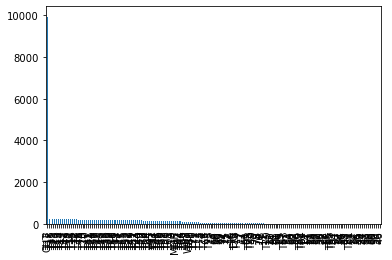

In [11]:
data['finish'].value_counts().plot(kind='bar')

__Due to the high amount of categories in the finish column this is basically unreadable.__
Let's check the count.

In [12]:
data['finish'].value_counts()

CUT    9936
T17     244
T18     237
T35     236
T23     235
       ... 
89        1
90        1
53        1
26        1
46        1
Name: finish, Length: 170, dtype: int64

As we already knew, we have a lot of different categories (170).  
The most common one being 'CUT', a bunch of good positions outside the top 10, usually tied, which probably is a reason those are so common and a lot of less common lower placements.  

Because the finish can (almost always) be deducted from the position, we can take a closer look at the position again jsut for fun.  
The finish column is likely going to be *irrelevant further on*, so we could leave it as it is for now.

<AxesSubplot:>

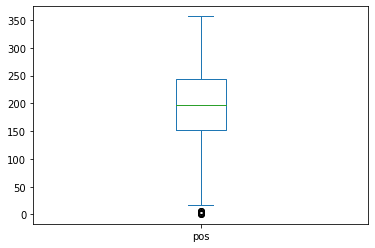

In [13]:
data['pos'].value_counts().plot(kind='box')

<AxesSubplot:ylabel='Frequency'>

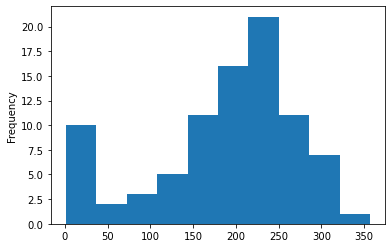

In [14]:
data['pos'].value_counts().plot(kind='hist')

In [15]:
data['pos'].mode()

0    2.0
dtype: float64

The distribution of 'pos' is looking pretty much as expected, but it's better to move and finally take care of the missing values in actually relevant columns.

### Strategy for replacing missing values
We will replace all missing values - excluding 'pos' and 'finish' with the mean grouped by player_id, because the distributions appear to be very symmetrical.  
For 'pos' we will use the median per palyer_id, not the mode, because the data is skewed, but the mode is 2, which does not make sense as a value to replace the missing data, because that amount of 2nd places is highly unlikely.

In [16]:
data['pos'].fillna(data.groupby('player_id')['pos'].transform('median'), inplace=True)

data['sg_putt'].fillna(data.groupby('player_id')['sg_putt'].transform('mean'), inplace=True)
data['sg_arg'].fillna(data.groupby('player_id')['sg_arg'].transform('mean'), inplace=True)
data['sg_app'].fillna(data.groupby('player_id')['sg_app'].transform('mean'), inplace=True)
data['sg_ott'].fillna(data.groupby('player_id')['sg_ott'].transform('mean'), inplace=True)
data['sg_t2g'].fillna(data.groupby('player_id')['sg_t2g'].transform('mean'), inplace=True)
data['sg_total'].fillna(data.groupby('player_id')['sg_total'].transform('mean'), inplace=True)

Let's see if there is any missing values outside of 'finish' left.

In [17]:
data.isnull().sum()

player_initial_last       0
tournament_id             0
player_id                 0
hole_par                  0
strokes                   0
made_cut                  0
pos                     222
player                    0
tournament_name           0
course                    0
date                      0
season                    0
finish                 5001
sg_putt                 124
sg_arg                  124
sg_app                  124
sg_ott                  124
sg_t2g                  124
sg_total                124
dtype: int64

There are still values missing, meaning that we were not able to replace them with the mean/median of the corresponding player_id, telling us that some players were missing all of the data in those columns.  
We have the possibilities of either dropping and disregarding all of those players or using the overall mean/median.  
I chose to use the overall values here.

In [18]:
# list to make it more readable
cols_missing_vals = ['sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g', 'sg_total']
# replace the missing values
data[cols_missing_vals] = data[cols_missing_vals].fillna(data[cols_missing_vals].mean())

data['pos'] = data['pos'].fillna(data['pos'].mean())

And check for missing values again.

In [19]:
data.isnull().sum()

player_initial_last       0
tournament_id             0
player_id                 0
hole_par                  0
strokes                   0
made_cut                  0
pos                       0
player                    0
tournament_name           0
course                    0
date                      0
season                    0
finish                 5001
sg_putt                   0
sg_arg                    0
sg_app                    0
sg_ott                    0
sg_t2g                    0
sg_total                  0
dtype: int64

Ok, no missing values besides the finish column which I chose to ignore.

## Looking at the players
Now I want to take a look at some players I like and/or find interesting.  
I will start by creating functions, so the code is reproducable for several players.

In [20]:
# func to get amount of cuts made ot not made for a player
def pl_cut(name, output=True, dic=True):
    '''
    :parameter: name: string of a players full name like in column 'player'
    :parameter: output: True prints out the results, False returns them as variable, default: True
    :parameter: dic: (output needs to be False!) True to return a dict, false to return a tuple
    :return: amount_cut_not_made: number of times player has not made the cut
    :return: amount_cut_made: number of times a player has made the cut
    :return: perc_cuts_made: percentage of made cuts
    '''
    # find amount of times player has not made the cut
    player_cut = data[data['player']==name][data[data['player']==name]['made_cut']==0]
    amount_cut_not_made = player_cut['made_cut'].count()
    
    # find amount of times player has made the cut
    player_cut = data[data['player']==name][data[data['player']==name]['made_cut']==1]
    amount_cut_made = player_cut['made_cut'].count()
    
    # calculate percentage of made cuts
    perc_cuts_made = round((amount_cut_made / (amount_cut_made + amount_cut_not_made)) * 100, 2)
    
    if output:
        # print out the results (default)
        print(f'{name}\nCut not made: {amount_cut_not_made}\nCut made: {amount_cut_made}\nPercentage made cuts: {perc_cuts_made}%')
    elif dic:
        # return values in dict
        return {'Amount_cut_not_made':amount_cut_not_made, 'Amount_cut_made':amount_cut_made, 'Percentage_cuts_made':perc_cuts_made}
    else:
        # return the values
        return amount_cut_not_made, amount_cut_made, perc_cuts_made

In [21]:
# func to get the mean of shots gained in each part of the game
def pl_mean_sg(name, output=True, dic=True):
    '''
    :parameter: name: string of a players full name like in column 'player'
    :parameter: output: True prints out the results, False returns them as variable, default: True
    :parameter: dic: (output needs to be False!) True to return a dict, false to return a tuple
    :return: either dict with mean shots gained per part of the game or tuple
    '''
    # compute the means
    sg_putt_mean = data[data['player']==name]['sg_putt'].mean()
    sg_arg_mean = data[data['player']==name]['sg_arg'].mean()
    sg_app_mean = data[data['player']==name]['sg_app'].mean()
    sg_ott_mean = data[data['player']==name]['sg_ott'].mean()
    sg_t2g_mean = data[data['player']==name]['sg_t2g'].mean()
    sg_total_mean = data[data['player']==name]['sg_total'].mean()
    
    if output:
        # print result (default)
        print(f'{name}\nSG putt mean: {sg_putt_mean}\nSG ARG mean: {sg_arg_mean}\nSG App mean: {sg_app_mean}\nSG OTT mean: {sg_ott_mean}\nSG T2G mean: {sg_t2g_mean}\nSG total mean: {sg_total_mean}')
    elif dic:
        # return results as dict
        return {'Putting':sg_putt_mean, 'Around_the_Green':sg_arg_mean, 'Approach':sg_app_mean, 
                'Off_the_Tee':sg_ott_mean, 'Tee_to_Green':sg_t2g_mean, 'Total':sg_total_mean}
    else:
        return sg_putt_mean, sg_arg_mean, sg_app_mean, sg_ott_mean, sg_t2g_mean, sg_total_mean

In [22]:
# func to get part of game with max shots gained for a player (disregarding total and t2g)
def pl_minmax_sg(sg_dict, output=True, dict=True):
    '''
    :parameter: sg_dict: dict with shots gained and the part of game as key (!!!use pl_mean_sg with output=False!!!)
    :parameter: output: True prints out the results, False returns them as variable, default: True
    :parameter: dic: (output needs to be False!) True to return a dict, false to return a tuple
    :return: either dict with part of game with min and max shots gained or a tuple
    '''
    # remove total and t2g, as they are expected to always be the highest
    sg_dict.pop('Total')
    sg_dict.pop('Tee_to_Green')
    
    # get the corresponding key for the min and max values
    min_sg = min(sg_dict, key=sg_dict.get)
    max_sg = max(sg_dict, key=sg_dict.get)
    
    if output:
        print(f'Min. shots gained: {min_sg}\nMax. shots gained: {max_sg}')
    elif dict:
        return {'Min_SG':min_sg, 'Max_SG':max_sg}
    else:
        return min_sg, max_sg

## Justin Thomas
I am starting by taking a closer look at Justin Thomas' game.

In [23]:
pl_cut('Justin Thomas', output=False)

{'Amount_cut_not_made': 16,
 'Amount_cut_made': 103,
 'Percentage_cuts_made': 86.55}

#### Cuts made by Justin Thomas
Justin Thomas made 103 cuts out of 119 between 2017 and 2022. That are 86.55%

#### In which part of his game does Justin Thomas gain the most or least shots?

In [24]:
pl_mean_sg('Justin Thomas')

Justin Thomas
SG putt mean: 0.028571428571428536
SG ARG mean: 0.2958241758241756
SG App mean: 0.7691208791208786
SG OTT mean: 0.3531868131868133
SG T2G mean: 1.418241758241758
SG total mean: 1.4606593406593396


In [25]:
pl_minmax_sg(pl_mean_sg('Justin Thomas', output=False))

Min. shots gained: Putting
Max. shots gained: Approach


Justin Thomas has the highest amount of shots gained during his approach while he struggles with gaining shots whilst putting.  
This is disregarding shots gained in total and tee to green, as these values are expected to always be the highest and including them would give us no interesting information about the players game.

## Rory McIlroy

In [26]:
pl_cut('Rory McIlroy')

Rory McIlroy
Cut not made: 11
Cut made: 82
Percentage made cuts: 88.17%


Rory McIlroy made 82 cuts while being cut 11 times, which makes less successful in making cuts than Justin Thomas.

In [27]:
pl_mean_sg('Rory McIlroy')

Rory McIlroy
SG putt mean: 0.04298507462686569
SG ARG mean: 0.20582089552238816
SG App mean: 0.43044776119402983
SG OTT mean: 0.8032835820895522
SG T2G mean: 1.4389552238805965
SG total mean: 1.4817910447761191


In [28]:
pl_minmax_sg(pl_mean_sg('Rory McIlroy', output=False))

Min. shots gained: Putting
Max. shots gained: Off_the_Tee


Just like Justin Thomas Rory McIlroy has the least shots gained while putting. While Justin Thomas is strong under approach Rory McIlroy seems to be a lot stronger off the tee where you would ususally expect him to use the woods more.  

Next I want to look at a player that is known for his short game around the green.  
## Phil Mickelson

In [29]:
pl_cut('Phil Mickelson')

Phil Mickelson
Cut not made: 28
Cut made: 75
Percentage made cuts: 72.82%


In [30]:
pl_mean_sg('Phil Mickelson')

Phil Mickelson
SG putt mean: 0.07953488372093025
SG ARG mean: 0.0963953488372093
SG App mean: -0.00569767441860459
SG OTT mean: -0.20139534883720936
SG T2G mean: -0.11069767441860479
SG total mean: -0.06476744186046522


In [31]:
pl_minmax_sg(pl_mean_sg('Phil Mickelson', output=False))

Min. shots gained: Off_the_Tee
Max. shots gained: Around_the_Green


As expected Phil Mickelson excels around the green as he is rightfully known to be a brilliant player when it comes to using his wedges. Compared to the other players I looked at so far he also is doing better with putting. However the rest of his game is looking worse with him on average needing more shots in total than the average player on tour.

## Bryson DeChambeau
As Bryson DeChambeau is know for his very long drives along with his unorthodox same length irons and golf physics nerdhood, I would expect him to gain the most shots against the filed off the tee.

In [32]:
pl_cut('Bryson DeChambeau')

Bryson DeChambeau
Cut not made: 30
Cut made: 90
Percentage made cuts: 75.0%


In [33]:
pl_mean_sg('Bryson DeChambeau')

Bryson DeChambeau
SG putt mean: 0.10829787234042552
SG ARG mean: -0.01776595744680851
SG App mean: 0.1519148936170213
SG OTT mean: 0.667765957446808
SG T2G mean: 0.8027659574468083
SG total mean: 0.9111702127659569


In [34]:
pl_minmax_sg(pl_mean_sg('Bryson DeChambeau', output=False))

Min. shots gained: Around_the_Green
Max. shots gained: Off_the_Tee


As expected he gains the most shots off the tee and actually falls back around the green.

## Where do winners gain shots?

In [38]:
# create a df with everyone finishing first
winners_df = data[data['pos']==1]
# take a look
winners_df.head(3)

,player_initial_last,tournament_id,player_id,hole_par,strokes,made_cut,pos,player,tournament_name,course,date,season,finish,sg_putt,sg_arg,sg_app,sg_ott,sg_t2g,sg_total
16,B. Horschel,401353224,1651,288,275,1,1.0,Billy Horschel,The Memorial Tournament pres. by Nationwide,"Muirfield Village Golf Club - Dublin, OH",2022-06-05,2022,1,0.95,1.31,1.25,0.84,3.39,4.35
204,S. Burns,401353225,9938,280,271,1,1.0,Sam Burns,Charles Schwab Challenge,"Colonial - Ft. Worth, TX",2022-05-29,2022,1,1.26,0.18,0.97,0.71,1.86,3.12
286,J. Thomas,401353226,4848,280,275,1,1.0,Justin Thomas,PGA Championship,"Southern Hills Country Club - Tulsa, OK",2022-05-22,2022,1,1.58,0.81,0.53,0.66,2.00,3.58


In [41]:
# compute the means
win_sg_putt_mean = winners_df['sg_putt'].mean()
win_sg_arg_mean = winners_df['sg_arg'].mean()
win_sg_app_mean = winners_df['sg_app'].mean()
win_sg_ott_mean = winners_df['sg_ott'].mean()
win_sg_t2g_mean = winners_df['sg_t2g'].mean()
win_sg_total_mean = winners_df['sg_total'].mean()

print(f'For position 1:\nSG putt mean: {win_sg_putt_mean}\nSG ARG mean: {win_sg_arg_mean}\nSG App mean: {win_sg_app_mean}\nSG OTT mean: {win_sg_ott_mean}\nSG T2G mean: {win_sg_t2g_mean}\nSG total mean: {win_sg_total_mean}')

For position 1:
SG putt mean: 0.9851039506647092
SG ARG mean: 0.3515260458081612
SG App mean: 1.063909973755646
SG OTT mean: 0.5637759976029378
SG T2G mean: 1.9799892742860565
SG total mean: 2.9480198196833003


We can see that winners of a PGA Tour tournament on average gain the most shots tee to green and disregarding that **during approach**. The short game seems to be less deciding than the long game.  
Let's see if we can see any obvious relationship between the features for our winners:

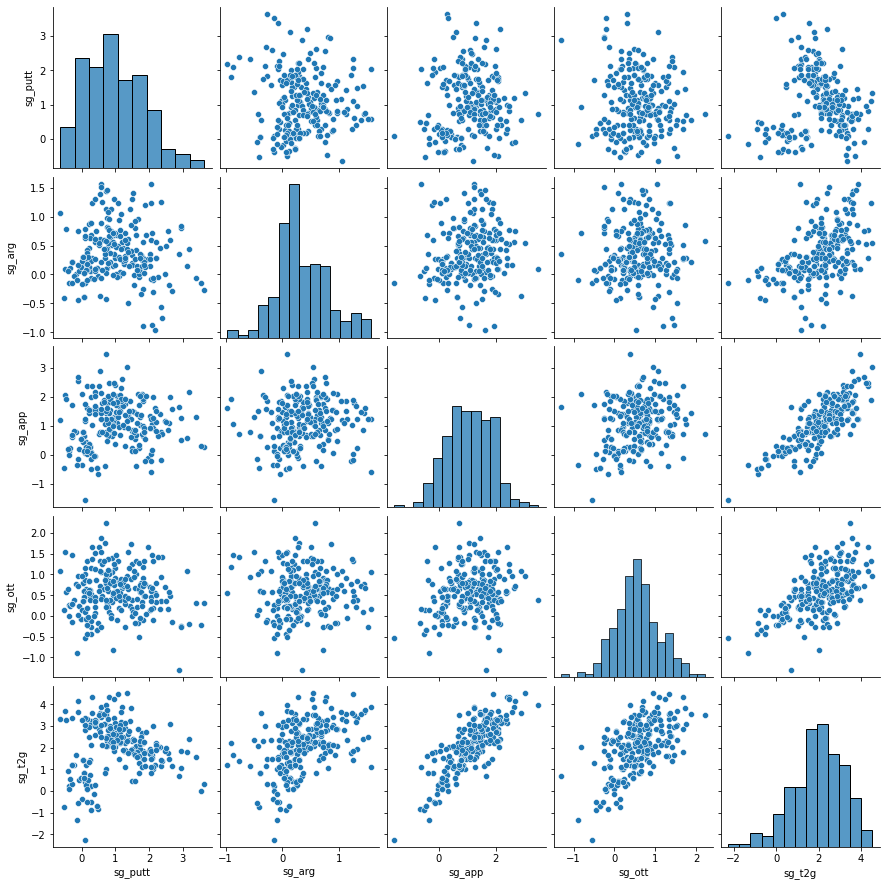

In [72]:
g = sns.pairplot(winners[['sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g']])
plt.show()